# FMA: A Dataset For Music Analysis

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Baselines

* This notebook evalutates standard classifiers from scikit-learn on the provided features.
* Moreover, it evaluates Deep Learning models on both audio and spectrograms.

In [1]:
import time
import os

import IPython.display as ipd
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import pickle

import utils

Using TensorFlow backend.


In [21]:
AUDIO_DIR = os.environ.get('')

tracks = utils.load('data/tracks.csv')
features = utils.load('data/features.csv')
echonest = utils.load('data/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, features.shape, echonest.shape

((106574, 52), (106574, 518), (13129, 249))

## Subset

In [22]:
subset = tracks.index[tracks['set', 'subset'] <= 'medium']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

Not enough Echonest features: (13129, 767)


((25000, 52), (25000, 518))

In [23]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

genres = list(MultiLabelBinarizer().fit(tracks['track', 'genre_top']).classes_)
#genres = list(tracks['track', 'genre_top'].unique())
print('Top genres ({}): {}'.format(len(genres), genres))
genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('All genres ({}): {}'.format(len(genres), genres))

19922 training examples, 2505 validation examples, 2573 testing examples
Top genres (35): [' ', '-', '/', 'B', 'C', 'E', 'F', 'H', 'I', 'J', 'L', 'O', 'P', 'R', 'S', 'T', 'a', 'c', 'd', 'e', 'g', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'x', 'y', 'z']
All genres (14): [' ', ',', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '[', ']']


## 1 Multiple classifiers and feature sets

Todo:
* Cross-validation for hyper-parameters.
* Dimensionality reduction?

### 1.1 Pre-processing

In [18]:
labels = set( tracks['track', 'genre_top'] )


In [25]:
labels

{nan,
 'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken'}

In [6]:
def pre_process(tracks, features, columns, multi_label=False, verbose=False):
    if not multi_label:
        # Assign an integer value to each genre.
        enc = LabelEncoder()
        labels = tracks['track', 'genre_top']
    else:
        # Create an indicator matrix.
        enc = MultiLabelBinarizer()
        labels = tracks['track', 'genres_all']
        #labels = tracks['track', 'genres']

    # Split in training, validation and testing sets.
    y_train = enc.fit_transform(labels[train])
    y_val = enc.transform(labels[val])
    y_test = enc.transform(labels[test])
    X_train = features.loc[train, columns].as_matrix()
    X_val = features.loc[val, columns].as_matrix()
    X_test = features.loc[test, columns].as_matrix()
    
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    
    # Standardize features by removing the mean and scaling to unit variance.
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(X_train)
    scaler.transform(X_val)
    scaler.transform(X_test)
    
    return y_train, y_val, y_test, X_train, X_val, X_test

### 1.2 Single genre

In [53]:
def test_classifiers_features(classifiers, feature_sets, multi_label=False):
    columns = list(classifiers.keys()).insert(0, 'dim')
    scores = pd.DataFrame(columns=columns, index=feature_sets.keys())
    times = pd.DataFrame(columns=classifiers.keys(), index=feature_sets.keys())
    
    for fset_name, fset in feature_sets.items():
        y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, fset, multi_label)
        scores.loc[fset_name, 'dim'] = X_train.shape[1]
        for clf_name, clf in classifiers.items():  # tqdm_notebook(classifiers.items(), desc='classifiers', leave=False):
            t = time.process_time()
            clf.fit(X_train, y_train)
            y_pred =  clf.predict(X_test)
            
            cm  = confusion_matrix(y_test, y_pred)
            percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T) 
            fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
            ax = fig.add_subplot(111)
            ax.grid(b=False)
            cax = ax.matshow(percent, cmap=plt.cm.Blues)
            pylab.title('Confusion matrix of the classifier : '+ clf_name +'\n')
            fig.colorbar(cax)
            
            for x,Y in enumerate(percent):
                for a,b in enumerate(Y):
                    ax.text(x,a,b,va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
                    
                    
            pylab.xlabel('Predicted')
            pylab.ylabel('Actual')
            pylab.savefig('./'+clf_name+'.png')
            pylab.show()
            
            import pickle
            with open('./model/'+clf_name+'.pkl','wb') as model:
                pickle.dump(clf, model,protocol=2)
                
            score = clf.score(X_test, y_test)
            scores.loc[fset_name, clf_name] = score
            times.loc[fset_name, clf_name] = time.process_time() - t
            
    return scores, times

def format_scores(scores):
    def highlight(s):
        is_max = s == max(s[1:])
        return ['background-color: yellow' if v else '' for v in is_max]
    scores = scores.style.apply(highlight, axis=1)
    return scores.format('{:.2%}', subset=pd.IndexSlice[:, scores.columns[1]:])

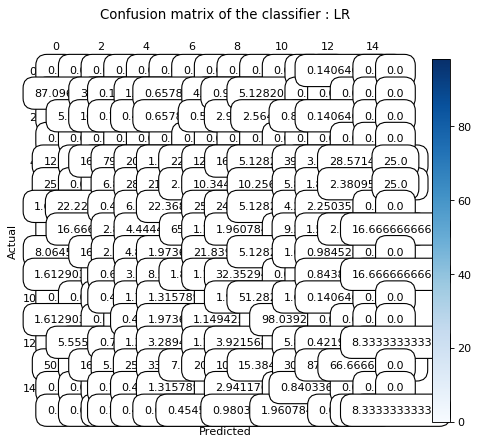

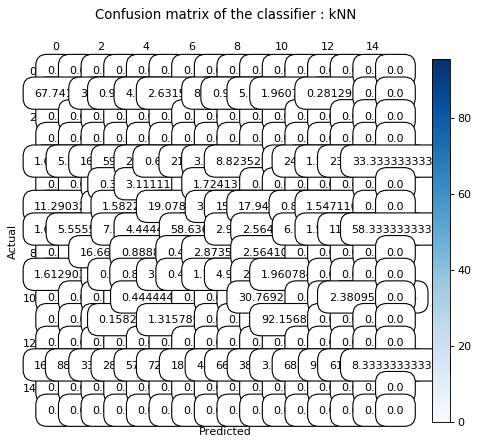

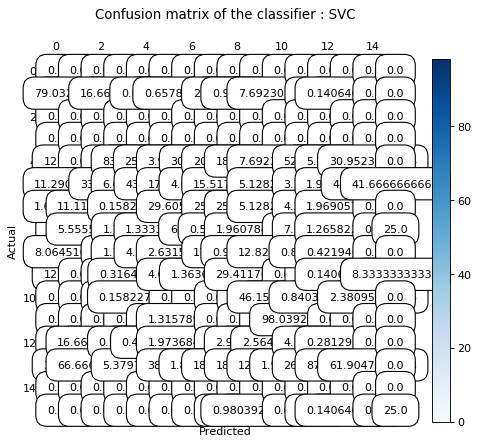

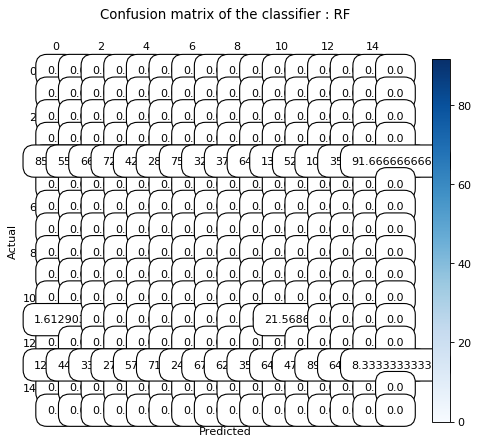

,dim,LR,kNN,SVC,RF
Features,518,61.10%,51.77%,62.88%,43.10%


,LR,kNN,SVC,RF
Features,310.7469,114.3440,270.6849,1.9779


In [54]:
classifiers = {
    'LR': LogisticRegression(),
    'kNN': KNeighborsClassifier(n_neighbors=200),
    'SVC': SVC(kernel='rbf'),
#     'SVCpoly1': SVC(kernel='poly', degree=1),
#     'linSVC1': SVC(kernel="linear"),
#     'linSVC2': LinearSVC(),
    #GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
#     'DT': DecisionTreeClassifier(max_depth=5),
    'RF': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     'AdaBoost': AdaBoostClassifier(n_estimators=10),
#     'MLP1': MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000),
#     'MLP2': MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=2000),
#     'NB': GaussianNB(),
#     'QDA': QuadraticDiscriminantAnalysis(),
}

feature_sets={
    'Features': list(features.columns.levels[0])
}

# # for name in features.columns.levels[0]:
# #     feature_sets[name] = name
# feature_sets.update({
#     'all_non-echonest': list(features.columns.levels[0])
# })

scores, times = test_classifiers_features(classifiers, feature_sets)

ipd.display(format_scores(scores))
ipd.display(times.style.format('{:.4f}'))

### 1.3 Multiple genres

Todo:
* Ignore rare genres? Count them higher up in the genre tree? On the other hand it's not much tracks.

In [9]:
classifiers = {
    #LogisticRegression(),
    'LR': OneVsRestClassifier(LogisticRegression()),
    'SVC': OneVsRestClassifier(SVC()),
    'MLP': MLPClassifier(max_iter=700),
}

feature_sets = {
#    'echonest_audio': ('echonest', 'audio_features'),
#    'echonest_temporal': ('echonest', 'temporal_features'),
    'mfcc': 'mfcc',
    'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
    'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],
}

scores, times = test_classifiers_features(classifiers, feature_sets, multi_label=True)

ipd.display(format_scores(scores))
ipd.display(times.style.format('{:.4f}'))

/Users/karunya/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label 12 is present in all training examples.
  str(classes[c]))
/Users/karunya/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label 13 is present in all training examples.
  str(classes[c]))
/Users/karunya/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label 12 is present in all training examples.
  str(classes[c]))
/Users/karunya/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label 13 is present in all training examples.
  str(classes[c]))
/Users/karunya/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label 12 is present in all training examples.
  str(classes[c]))
/Users/karunya/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label 13 is present in all training examples.
  str(classes[c]))
/Users/karunya/anaconda3/lib/python3.6/site-packages/sklea

,dim,LR,SVC,MLP
mfcc,140,6.53%,9.91%,9.64%
mfcc/contrast/chroma/centroid/tonnetz,322,8.67%,11.31%,8.67%
mfcc/contrast/chroma/centroid/zcr,287,8.47%,11.62%,9.29%


,LR,SVC,MLP
mfcc,38.2774,1455.2960,79.5061
mfcc/contrast/chroma/centroid/tonnetz,134.6299,3122.1257,136.8132
mfcc/contrast/chroma/centroid/zcr,114.4268,2726.1651,142.9205


## 2 Deep learning on raw audio

Other architectures:
* [Learning Features of Music from Scratch (MusicNet)](https://arxiv.org/abs/1611.09827), John Thickstun, Zaid Harchaoui, Sham Kakade.

In [31]:
labels_onehot = MultiLabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

Load audio samples in parallel using `multiprocessing` so as to maximize CPU usage when decoding MP3s and making some optional pre-processing. There are multiple ways to load a waveform from a compressed MP3:
* librosa uses audioread in the backend which can use many native libraries, e.g. ffmpeg
    * resampling is very slow --> use `kaiser_fast`
    * does not work with multi-processing, for keras `fit_generator()`
* pydub is a high-level interface for audio modification, uses ffmpeg to load
    * store a temporary `.wav`
* directly pipe ffmpeg output
    * fastest method
* [pyAV](https://github.com/mikeboers/PyAV) may be a fastest alternative by linking to ffmpeg libraries

In [30]:
# Just be sure that everything is fine. Multiprocessing is tricky to debug.
utils.FfmpegLoader().load(utils.get_audio_path(AUDIO_DIR, 2))
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, utils.FfmpegLoader())
SampleLoader(train, batch_size=2).__next__()[0].shape

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [46]:
# Keras parameters.
NB_WORKER = int( os.popen('sysctl -n hw.ncpu').read().strip('\n') ) # number of usables CPUs
params = {'pickle_safe': True, 'nb_worker': NB_WORKER, 'max_q_size': 10}

### 2.1 Fully connected neural network

* Two layers with 10 hiddens is no better than random, ~11%.

Optimize data loading to be CPU / GPU bound, not IO bound. Larger batches means reduced training time, so increase batch time until memory exhaustion. Number of workers and queue size have no influence on speed.

In [ ]:
loader = utils.FfmpegLoader(sampling_rate=2000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)
print('Dimensionality: {}'.format(loader.shape))

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Dense(output_dim=1000, input_shape=loader.shape))
model.add(Activation("relu"))
model.add(Dense(output_dim=100))
model.add(Activation("relu"))
model.add(Dense(output_dim=labels_onehot.shape[1]))
model.add(Activation("softmax"))

optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=64), train.size, nb_epoch=2, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=64), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=64), test.size, **params)
#Y = model.predict_generator(SampleLoader(test, batch_size=64), test.size, **params);

loss

### 2.2 Convolutional neural network

* Architecture: [End-to-end learning for music audio](http://www.mirlab.org/conference_papers/International_Conference/ICASSP%202014/papers/p7014-dieleman.pdf), Sander Dieleman, Benjamin Schrauwen.
* Missing: track segmentation and class averaging (majority voting)
* Compared with log-scaled mel-spectrograms instead of strided convolution as first layer.
* Larger net: http://benanne.github.io/2014/08/05/spotify-cnns.html

In [ ]:
loader = utils.FfmpegLoader(sampling_rate=16000)
#loader = utils.LibrosaLoader(sampling_rate=16000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Reshape((-1, 1), input_shape=loader.shape))
print(model.output_shape)

model.add(Conv1D(128, 512, subsample_length=512))
print(model.output_shape)
model.add(Activation("relu"))

model.add(Conv1D(32, 8))
print(model.output_shape)
model.add(Activation("relu"))
model.add(MaxPooling1D(4))

model.add(Conv1D(32, 8))
print(model.output_shape)
model.add(Activation("relu"))
model.add(MaxPooling1D(4))

print(model.output_shape)
#model.add(Dropout(0.25))
model.add(Flatten())
print(model.output_shape)
model.add(Dense(100))
model.add(Activation("relu"))
print(model.output_shape)
model.add(Dense(labels_onehot.shape[1]))
model.add(Activation("softmax"))
print(model.output_shape)

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
#optimizer = keras.optimizers.Adam()#lr=1e-5)#, momentum=0.9, nesterov=True)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=10), train.size, nb_epoch=20, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=10), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=10), test.size, **params)

loss

### 2.3 Recurrent neural network

## 3 Deep learning on extracted audio features

Look at:
* Pre-processing in Keras: https://github.com/keunwoochoi/kapre
* Convolutional Recurrent Neural Networks for Music Classification: https://github.com/keunwoochoi/icassp_2017
* Music Auto-Tagger: https://github.com/keunwoochoi/music-auto_tagging-keras
* Pre-processor: https://github.com/bmcfee/pumpp

### 3.1 ConvNet on MFCC

* Architecture: [Automatic Musical Pattern Feature Extraction Using Convolutional Neural Network](http://www.iaeng.org/publication/IMECS2010/IMECS2010_pp546-550.pdf), Tom LH. Li, Antoni B. Chan and Andy HW. Chun
* Missing: track segmentation and majority voting.
* Best seen: 17.6%

In [ ]:
class MfccLoader(utils.Loader):
    raw_loader = utils.FfmpegLoader(sampling_rate=22050)
    #shape = (13, 190)  # For segmented tracks.
    shape = (13, 2582)
    def load(self, filename):
        import librosa
        x = self.raw_loader.load(filename)
        # Each MFCC frame spans 23ms on the audio signal with 50% overlap with the adjacent frames.
        mfcc = librosa.feature.mfcc(x, sr=22050, n_mfcc=13, n_fft=512, hop_length=256)
        return mfcc

loader = MfccLoader()
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)
loader.load(utils.get_audio_path(AUDIO_DIR, 2))[0].shape

In [ ]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Reshape((*loader.shape, 1),  input_shape=loader.shape))
print(model.output_shape)

model.add(Conv2D(3, 13, 10, subsample=(1, 4)))
model.add(Activation("relu"))
print(model.output_shape)

model.add(Conv2D(15, 1, 10, subsample=(1, 4)))
model.add(Activation("relu"))
print(model.output_shape)

model.add(Conv2D(65, 1, 10, subsample=(1, 4)))
model.add(Activation("relu"))
print(model.output_shape)

model.add(Flatten())
print(model.output_shape)
model.add(Dense(labels_onehot.shape[1]))
model.add(Activation("softmax"))
print(model.output_shape)

optimizer = keras.optimizers.SGD(1e-3)#lr=0.01, momentum=0.9, nesterov=True)
#optimizer = keras.optimizers.Adam()#lr=1e-5)#
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=16), train.size, nb_epoch=20, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=16), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=16), test.size, **params)
#Y = model.predict_generator(loader, test.size, pickle_safe=True, nb_worker=NB_WORKER, max_q_size=5)

loss